In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.python.keras as krs
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
_df = pd.read_csv("Data/wig20_d.csv")
# df = pd.read_csv("Data/mwig40_d.csv")
# df = pd.read_csv("Data/swig80_d.csv")

_df.drop(range(1000), inplace=True)
_df.reset_index(inplace=True, drop=True)
_df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1997-02-06,1717.2,1779.8,1717.2,1779.8,4435886.0
1,1997-02-07,1778.2,1808.7,1778.2,1799.0,5448243.0
2,1997-02-10,1797.4,1797.4,1780.3,1783.3,6513315.0
3,1997-02-11,1803.3,1832.2,1803.3,1832.0,5146340.0
4,1997-02-12,1824.6,1824.6,1804.9,1810.2,5748398.0


In [3]:
_df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1997-02-06,1717.2,1779.8,1717.2,1779.8,4435886.0
1,1997-02-07,1778.2,1808.7,1778.2,1799.0,5448243.0
2,1997-02-10,1797.4,1797.4,1780.3,1783.3,6513315.0
3,1997-02-11,1803.3,1832.2,1803.3,1832.0,5146340.0
4,1997-02-12,1824.6,1824.6,1804.9,1810.2,5748398.0


In [4]:
_data_len = len(_df.index)
_train_set_ratio, _test_set_ratio, _validation_set_ratio = .8, .1, .1
scaler = MinMaxScaler(feature_range=(0,1))

_train_set_len = int(_data_len * _train_set_ratio)
_test_set_len = int(_data_len * _test_set_ratio)
_validation_set_len = int(_data_len * _validation_set_ratio)

_train_set_end = _train_set_len
_test_set_end = _train_set_end + _test_set_len
_validation_set_end = _test_set_end + _validation_set_len


colnames = _df.columns.to_numpy()
col_len = 5

_data = _df.to_numpy()[:, 1:col_len]
#_data = _data.flatten().reshape((-1, 1))
#_data = _df.to_numpy().transpose()[1:5, :]
_data = scaler.fit_transform(_data)


#train_set, test_set, validation_set = _df.iloc[:_train_set_end, :], _df.iloc[_train_set_end:_test_set_end, :], _df.iloc[_test_set_end:_validation_set_end, :]
train_set, test_set, validation_set = _data[:_train_set_end, :], _data[_train_set_end:_test_set_end, :], _data[_test_set_end:_validation_set_end, :]


In [5]:
colnames

array(['Data', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie',
       'Wolumen'], dtype=object)

In [6]:
train_set[:, :10]

array([[0.24675461, 0.26440479, 0.25373683, 0.27438683],
       [0.26746804, 0.27424346, 0.27448753, 0.28090288],
       [0.27398767, 0.27039651, 0.27520189, 0.27557465],
       ...,
       [0.46054432, 0.46188283, 0.46512182, 0.47124962],
       [0.46464965, 0.46812306, 0.46929237, 0.47715819],
       [0.47197745, 0.47321261, 0.47799065, 0.48053839]])

In [7]:
test_set[:, :10]

array([[0.47437138, 0.4740535 , 0.47738854, 0.48183481],
       [0.47701319, 0.49488832, 0.48440976, 0.50396563],
       [0.50061631, 0.50333459, 0.50617078, 0.5092158 ],
       ...,
       [0.14132328, 0.15874297, 0.14135308, 0.16905419],
       [0.17372791, 0.18540269, 0.17190764, 0.17549897],
       [0.15983293, 0.15687056, 0.14607472, 0.14734081]])

In [8]:
validation_set[:, :10]

array([[0.15579891, 0.15996514, 0.15404503, 0.16280625],
       [0.16884158, 0.1711213 , 0.15033031, 0.15968737],
       [0.14975127, 0.16672284, 0.14954451, 0.17671734],
       ...,
       [0.14393793, 0.14202745, 0.14544539, 0.14725936],
       [0.13913649, 0.13520506, 0.13880857, 0.13853056],
       [0.13145894, 0.13714216, 0.1324643 , 0.1393281 ]])

In [9]:
train_set.shape

(5143, 4)

In [10]:
def batches_create(data_array: np.array):
    _forecast = 1
    _x_train = np.array([data_array[i:i+60, :].astype("float32") for i in range(data_array.shape[0]-60-_forecast)])
    _y_train = np.array([data_array[i+60:i+60+_forecast, :].astype("float32") for i in range(data_array.shape[0]-60-_forecast)])
    print(_x_train.shape)
    print(_y_train.shape)
    #_x_train, _y_train = np.reshape(_x_train, (_x_train.shape[0], _x_train.shape[1], 1)), _y_train
    return _x_train, _y_train


In [11]:
X_train, y_train = batches_create(train_set)
X_test, y_test = batches_create(test_set)
X_validation, y_validation = batches_create(validation_set)


(5082, 60, 4)
(5082, 1, 4)
(581, 60, 4)
(581, 1, 4)
(581, 60, 4)
(581, 1, 4)


In [12]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[2]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2022-10-16 00:08:44.538038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-16 00:08:44.538067: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-16 00:08:44.538089: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (banjaro): /proc/driver/nvidia/version does not exist
2022-10-16 00:08:44.538410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


159/159 [==============================] - 19s 79ms/step - loss: 0.0518
Epoch 2/10
159/159 [==============================] - 14s 85ms/step - loss: 0.0471
Epoch 3/10
159/159 [==============================] - 17s 105ms/step - loss: 0.0467
Epoch 4/10
159/159 [==============================] - 18s 112ms/step - loss: 0.0464
Epoch 5/10
159/159 [==============================] - 17s 108ms/step - loss: 0.0461
Epoch 6/10
159/159 [==============================] - 16s 103ms/step - loss: 0.0457
Epoch 7/10
159/159 [==============================] - 16s 100ms/step - loss: 0.0457
Epoch 8/10
159/159 [==============================] - 17s 110ms/step - loss: 0.0459
Epoch 9/10
159/159 [==============================] - 17s 107ms/step - loss: 0.0454
Epoch 10/10
159/159 [==============================] - 17s 106ms/step - loss: 0.0453


In [13]:
#model = krs.models.load_model("Models/model_lstm_1")

In [14]:
X_test.shape

(581, 60, 4)

In [15]:
output_col_num = 0

In [16]:
prediction_test = model.predict(np.array(X_test))

19/19 [==============================] - 2s 22ms/step


In [40]:
prediction_test.shape

(581, 4)

In [18]:
y_t = scaler.inverse_transform(prediction_test)[:, output_col_num]

In [19]:
#scaler.inverse_transform(prediction_test)

In [20]:
y_t

array([2176.135 , 2176.0945, 2176.0278, 2175.942 , 2175.8494, 2175.7651,
       2175.699 , 2175.6558, 2175.636 , 2175.636 , 2175.6475, 2175.6577,
       2175.6519, 2175.6196, 2175.5593, 2175.474 , 2175.3696, 2175.2534,
       2175.1323, 2175.011 , 2174.8953, 2174.7913, 2174.7024, 2174.6338,
       2174.591 , 2174.5776, 2174.5923, 2174.6301, 2174.684 , 2174.7502,
       2174.825 , 2174.9014, 2174.9792, 2175.0645, 2175.1653, 2175.285 ,
       2175.4187, 2175.56  , 2175.7036, 2175.8457, 2175.985 , 2176.127 ,
       2176.2778, 2176.439 , 2176.6104, 2176.7908, 2176.9768, 2177.1616,
       2177.338 , 2177.498 , 2177.6355, 2177.7444, 2177.8188, 2177.8547,
       2177.8489, 2177.7942, 2177.687 , 2177.53  , 2177.3274, 2177.0894,
       2176.831 , 2176.568 , 2176.3157, 2176.0818, 2175.869 , 2175.6758,
       2175.4998, 2175.3376, 2175.189 , 2175.0544, 2174.9375, 2174.8347,
       2174.7344, 2174.6233, 2174.4924, 2174.343 , 2174.1816, 2174.0156,
       2173.851 , 2173.6978, 2173.5647, 2173.4539, 

In [21]:
np.array([X_test[0]])

array([[[0.47437137, 0.4740535 , 0.47738853, 0.4818348 ],
        [0.4770132 , 0.4948883 , 0.48440975, 0.5039656 ],
        [0.5006163 , 0.5033346 , 0.5061708 , 0.5092158 ],
        [0.503781  , 0.52117693, 0.50984126, 0.52943254],
        [0.5211939 , 0.51823896, 0.5130015 , 0.51798534],
        [0.515041  , 0.5222664 , 0.5211657 , 0.52714515],
        [0.519435  , 0.520765  , 0.520567  , 0.5243249 ],
        [0.5167965 , 0.5193999 , 0.52304006, 0.52818024],
        [0.517109  , 0.5183445 , 0.52283937, 0.5253973 ],
        [0.51971   , 0.52686226, 0.52453005, 0.5247288 ],
        [0.5166777 , 0.51922286, 0.52216923, 0.5230149 ],
        [0.5165792 , 0.519342  , 0.5139472 , 0.5160203 ],
        [0.5087183 , 0.5094625 , 0.51316476, 0.513234  ],
        [0.5089764 , 0.51783043, 0.5164305 , 0.5233678 ],
        [0.5187287 , 0.52187145, 0.5200567 , 0.52080214],
        [0.5151904 , 0.5171632 , 0.51983905, 0.51886094],
        [0.51329565, 0.5133605 , 0.51945466, 0.5213282 ],
        [0.514

In [22]:
X_test.shape

(581, 60, 4)

In [23]:
y_test

array([[[0.48829353, 0.48870936, 0.48921305, 0.48863932]],

       [[0.48290125, 0.49110264, 0.4896859 , 0.49974376]],

       [[0.49156353, 0.49949104, 0.4966799 , 0.50797707]],

       ...,

       [[0.1476256 , 0.15743227, 0.13792412, 0.145929  ]],

       [[0.14132328, 0.15874296, 0.14135309, 0.1690542 ]],

       [[0.1737279 , 0.18540269, 0.17190763, 0.17549898]]], dtype=float32)

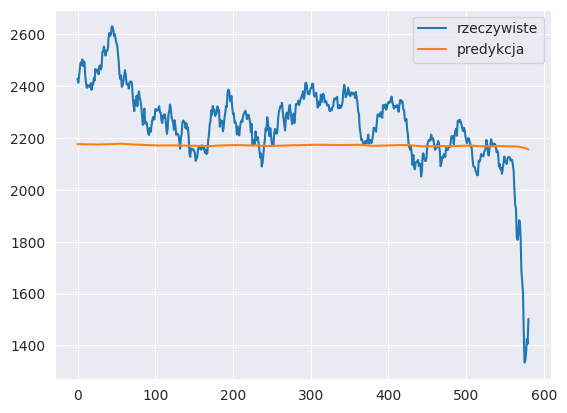

In [39]:
y_test = y_test.reshape(-1, col_len-1)
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test)[:, output_col_num], label="rzeczywiste")
plt.plot(range(len(y_test)), y_t, label="predykcja")
plt.legend()

In [ ]:
prediction_validation = model.predict(X_validation)

In [ ]:
prediction_validation

In [ ]:
y_v = scaler.inverse_transform(prediction_validation)[:, output_col_num]

In [ ]:
plt.plot(range(len(y_validation)), scaler.inverse_transform(y_validation)[:, output_col_num], label="rzeczywiste")
plt.plot(range(len(y_validation)), y_v, label="predykcja")
plt.legend()

In [ ]:
deltas_test = y_t - scaler.inverse_transform(y_test)[:, output_col_num]

In [ ]:
plt.hist(deltas_test, bins=50)

In [ ]:
deltas_validation = y_v - scaler.inverse_transform(y_validation)[:, output_col_num]

In [ ]:
plt.hist(deltas_validation, bins=50)

In [ ]:
#model.save("Models/tmp")